# Predicting Flight Delays

This project was inspired by [this hortonworks project](http://hortonworks.com/blog/data-science-apacheh-hadoop-predicting-airline-delays/)

This notebook explores a subset of the data, and then goes into the actual predicting with sklearn. Apache Spark, and it's MlLib libarary, will be used to predict with the whole dataset.

In [15]:
import warnings
warnings.filterwarnings('ignore')

import glob
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from datetime import date
from sklearn import linear_model, cross_validation, metrics, svm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

%matplotlib inline

# Flag variables to run certain cells
DO_GRAPHS = True
DO_ITER_1 = True # skip first iteration, takes awhile to train & fit
DO_ITER_2 = False

Read the monthly CSVs into a DataFrame

In [2]:
#path = '/home/william/Projects/flight-delay/data'
#allFiles = glob.glob(os.path.join(path, '2016*.csv'))
# sort by date
#allFiles.sort(key=lambda path: int(int(path.split('/')[-1][:-4])))
# read in using generator expr for all CSV files
#flights2016 = pd.concat( (pd.read_csv(f, usecols=range(29)) for f in allFiles) )
base = '/home/william/Projects/flight-delay/data/merged'
flights = pd.read_csv(os.path.join(base, '2015.csv'), usecols=range(29))
flights = pd.concat([flights, 
                    pd.read_csv(os.path.join(base, '2016.csv'), usecols=range(29), nrows=2500000)])

Drop excess columns, rename others

In [3]:
renamed_cols = [
        'Year', 'Month', 'Day', 'Dow','CarrierId', 'Carrier', 'TailNum', 'Origin', 
        'Dest', 'CRSDepTime', 'DepTime', 'DepDelay', 'TaxiOut', 'TaxiIn', 'CRSArrTime', 
        'ArrTime', 'ArrDelay', 'Cancelled', 'CancellationCode', 'Diverted', 'CRSElapsedTime', 
        'ActualElapsedTime', 'AirTime', 'Distance', 'CarrierDelay', 'WeatherDelay', 
        'NASDelay', 'SecurityDelay', 'LateAircraftDelay'
]
flights.columns = renamed_cols
to_keep = ['Year', 'Month', 'Day', 'Dow', 'Carrier', 'Origin', 'Dest', 
           'DepDelay', 'CRSDepTime', 'Distance']
    
to_drop = list( set(renamed_cols) - set(to_keep))

flights.drop(to_drop, axis=1, inplace=True)
# filter the DF down to only flights originating out of ORD, due to memory
flights = flights[ flights['Origin'] == 'ORD' ]
flights.dropna(subset=['DepDelay'], inplace=True)
# boolean column indicating whether flight was delayed, to certain threshold
flights['Delayed'] = flights['DepDelay'] >= 15
# reindex after dropping to keep consecuitive indices
flights.index = range(len(flights))

In [4]:
print('Total Flights:', flights.shape[0])
print('Total Delays:', flights['Delayed'].sum())

Total Flights: 404459
Total Delays: 91685


Graph of delays per month

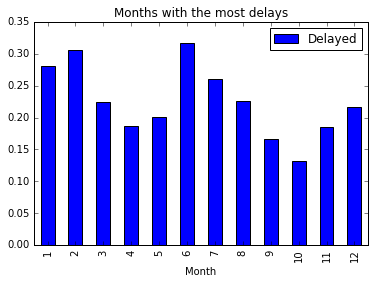

In [5]:
if DO_GRAPHS:
    # Compute average number of delayed flights per month
    flights['Delayed'] = flights['DepDelay'] >= 15
    grouped = flights[['Delayed', 'Month']].groupby('Month').mean()

    # plot average delays by month
    grouped.plot(kind='bar')
    plt.title('Months with the most delays')

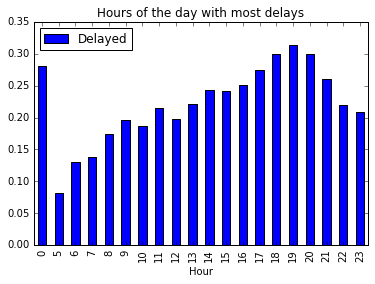

In [6]:
if DO_GRAPHS:
    flights['Hour'] = flights['CRSDepTime'].map(lambda x: x // 100)
    flights.drop('CRSDepTime', axis=1, inplace=True)
    grouped = flights[['Delayed', 'Hour']].groupby('Hour').mean()

    # plot average delays by hour of day
    grouped.plot(kind='bar')
    plt.title('Hours of the day with most delays')

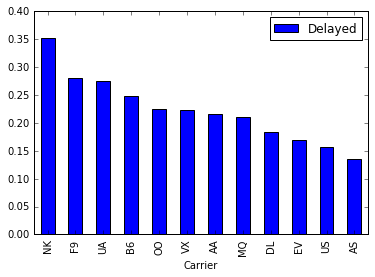

In [7]:
if DO_GRAPHS:
    grped1 = flights[ ['Delayed', 'Carrier'] ].groupby('Carrier').filter(lambda x: len(x) > 10)
    grped1 = grped1.groupby('Carrier').mean()
    grped1 = grped1.sort(['Delayed'], ascending=False)

    grped1[:15].plot(kind='bar')

New Year's Day, MLK Day, Easter, Memorial day, July 4th, Labor Day,
Columbus Day, Veterans Day, Thanksgiving, Christmas

In [8]:
if DO_GRAPHS:
    %reset_selective -f grped1
    %reset_selective -f grped2
    %reset_selective -f carrier
    %reset_selective -f grouped
    %reset_selective -f df

## Building a feature matrix


In [9]:
renamed_cols = ['Year', 'Month', 'Day', 'Dow', 'Carrier', 'Origin', 
                'Dest', 'Delay', 'Distance', 'Delayed', 'Hour']
flights.columns = renamed_cols
# convert the numeric columns from object dtype
numeric_cols = ['Year', 'Month', 'Day', 'Dow', 'Delay', 'Hour', 'Distance']
for col in numeric_cols:
    flights[col] = pd.to_numeric( flights[col] )

Creating Nearest holiday lookup table for 2015 and 2016

New Year's Day, MLK Day, Easter, Memorial day, July 4th, Labor Day, Veteran's Day, Columbus Day, Veteran's Day, Thanksgiving, Christmas 

In [10]:
from datetime import timedelta, date

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)
        
holidays_2015 = [
    date(2015, 1, 1), date(2015, 1, 19), date(2015, 4, 5), date(2015, 5, 25),
    date(2015, 7, 4), date(2015, 9, 7), date(2015, 10, 12), date(2015, 11, 11),
    date(2015, 11, 26), date(2015, 12, 25)
]
holidays_2016 = [
    date(2016, 1, 1), date(2016, 1, 18), date(2016, 3, 27), date(2016, 5, 30),
    date(2016, 7, 4),  date(2016, 9, 5), date(2016, 10, 10), date(2016, 11, 11),
    date(2016, 11, 24), date(2016, 12, 25)
]

hday_lookup = {}
for d in daterange( date(2015, 1, 1), date(2017, 1, 1) ):
    holidays = holidays_2015 if d.year == 2015 else holidays_2016
    hday_lookup[d] = min( (abs(d- holiday).days for holiday in holidays) )

Calculating the number of days to the nearest holiday for each row. 

To do this efficiently, first I group by date (since there are thousands of flights for each day), then lookup the date in the lookup table. 

In [11]:
grp_to_indices = flights.groupby(['Year', 'Month','Day']).indices
for d in daterange( date(2015, 1, 1), date(2017, 1, 1)):
    grp_label = (d.year, d.month, d.day)
    if grp_label in grp_to_indices:
        indices = grp_to_indices[grp_label]
        flights.loc[indices, 'HDays'] = hday_lookup[ date(*grp_label) ]
year_masks = flights.groupby('Year').indices

Create training and test data -- with just the numeric data

In [12]:
if DO_ITER_1:
    X_cols = ['Month', 'Day', 'Dow', 'Hour', 'Distance', 'HDays']
    X_train = flights.loc[ year_masks[2015], X_cols ]
    X_test = flights.loc[ year_masks[2016], X_cols ]

    Y_train = flights.loc[ year_masks[2015], 'Delayed' ]
    Y_test = flights.loc[ year_masks[2016], 'Delayed' ]


Running Logistic Regression model -- no encoding

In [16]:
if DO_ITER_1:

    clf_lr = linear_model.LogisticRegression(penalty='l2', class_weight='balanced')
    clf_lr.fit(X_train, Y_train)

    predictions = clf_lr.predict(X_test)

    # evaluate predictions
    cm = confusion_matrix(Y_test, predictions)
    print('Confusion Matrix')
    print(pd.DataFrame(cm))
    lr_report= precision_recall_fscore_support(list(Y_test), list(predictions), 
                                               average='micro')
    print("\nprecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % \
            (lr_report[0], lr_report[1], lr_report[2], accuracy_score(list(Y_test), list(predictions))))

    %reset_selective -f clr_lr

Confusion Matrix
       0      1
0  24588  54262
1   3672  16580

precision = 0.23, recall = 0.82, F1 = 0.36, accuracy = 0.42



In [17]:
if DO_ITER_1:
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.preprocessing import StandardScaler

    clr_rf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
    clr_rf.fit(X_train, Y_train)

    predictions = clr_rf.predict(X_test)

    # evaluate predictions
    cm = confusion_matrix(Y_test, predictions)
    print('Confusions Matrix')
    print(pd.DataFrame(cm))
    svm_report = precision_recall_fscore_support(list(Y_test), list(predictions),
                                                average='binary')
    print("\nprecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % \
            (svm_report[0], svm_report[1], svm_report[2], 
             accuracy_score(list(Y_test), list(predictions))))
    # reset since it takes a *huge* amount of memory
    %reset_selective -f clr_rf

Confusions Matrix
       0     1
0  69327  9523
1  16454  3798

precision = 0.29, recall = 0.19, F1 = 0.23, accuracy = 0.74



Due to memory constraints, an online learning algorithm must be implemented. So, the features must be encoded into a sparse matrix, and then a ridge regression model will create the best model depedning on various training/testing splits.

In [18]:
if DO_ITER_2:
    from sklearn.preprocessing import OneHotEncoder
    Y_train = flights.loc[year_masks[2015], 'Delay'] >= 15
    Y_test = flights.loc[year_masks[2016], 'Delay'] >= 15

    cats = ['Month', 'Day', 'Dow', 'Hour', 'Carrier', 'Origin', 'Dest']
    # convert String categories to numerical -- to be compatible w/ sklearn
    flights['Carrier'] = pd.factorize(flights['Carrier'])[0]
    flights['Origin'] = pd.factorize(flights['Origin'])[0]
    flights['Dest'] = pd.factorize(flights['Dest'])[0]
    
    enc = OneHotEncoder()
    X = enc.fit_transform( flights.loc[year_masks, cats] )
    X_train